In [5]:
import requests
import pandas as pd
import matplotlib.ticker as mtick
import pickle
#r = requests.post('http://135.125.83.106/analyze', json={'fileType': ['softcite'], 'download': True, 'concat': True})

# 1. Data from BSO : répartition discipline, année

In [6]:
from elasticsearch import Elasticsearch, helpers
es = Elasticsearch('https://cluster.elasticsearch.dataesr.ovh/', http_auth=('elastic', open('.env').read().strip()))
res = es.search(index='bso-publications', request_cache=False, body={'size': 0,
                                                                     'query':{'bool': {}},
     'aggs': {'year': {'terms': {'field': 'year', 'size':20},
       'aggs': {'domain': {'terms': {'field': 'bso_classification.keyword', 'size':20}}}
             }}}
                           )
bso = []
for e in res['aggregations']['year']['buckets']:
    year = e['key']
    if not (2013<=year<=2020):
        continue
    for d in e['domain']['buckets']:
        bso.append({'year': year, 'domain': d['key'], 'nb': d['doc_count'], 'perc': d['doc_count']/e['doc_count']})
df_bso = pd.DataFrame(bso).sort_values(by='year')
df_bso[df_bso.domain=='Social sciences']

,year,domain,nb,perc
83,2013,Social sciences,9482,0.066349
61,2014,Social sciences,9667,0.066438
72,2015,Social sciences,9741,0.066977
50,2016,Social sciences,9989,0.064212
39,2017,Social sciences,10242,0.064880
28,2018,Social sciences,10846,0.065818
17,2019,Social sciences,10582,0.063598
6,2020,Social sciences,9293,0.054948


In [72]:
df_ext = pd.read_csv('/Users/eric/Downloads/bso-publications-latest.csv.gz')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [179]:
df_ext.is_oa.value_counts(normalize=True)

True     0.514316
False    0.485684
Name: is_oa, dtype: float64

In [178]:
420000/696000

0.603448275862069

# Utility functions

In [55]:
def analyze_mention(m):
    elt = {'name': m['software-name']['rawForm'], 
           'name_normalized': m['software-name']['normalizedForm'],
            'has_wikidata': False,
           'context': m.get('context'),
           'confience': m.get('confidence'),
          'used': m['documentContextAttributes']['used']['value'],
          'shared': m['documentContextAttributes']['shared']['value'],
          'created': m['documentContextAttributes']['created']['value']}
    if 'wikidataId' in m['software-name']:
        elt['wikidataId'] = m['software-name']['wikidataId']
        assert(m['wikidataId'] == elt['wikidataId'])
        elt['has_wikidata'] = True
    return elt
    

In [390]:
def merge_mentions(name, mentions, created_soft = {}):
    res = {'name': name, 'nb_mentions': len(mentions)}
    contexts = []
    used = mentions[0]['used']
    shared = mentions[0]['shared']
    created = mentions[0]['created']
    created_shared = created and shared
    has_wikidata = False
    for mention in mentions:
        has_wikidata = has_wikidata or mention.get('wikidataId')
        used = used or mention['used'] 
        shared = shared or mention['shared']
        created = created or mention['created']
        created_shared = created_shared or (mention['created'] and mention['shared'])
        if mention.get('context'):
            contexts.append(mention['context'])
    res['used'] = used
    res['shared'] = shared
    res['created'] = created
    res['created_treated'] = created
    res['created_shared'] = created_shared
    if name in created_soft and len(created_soft[name]) > 1:
        res['created_treated'] = False
    if has_wikidata:
        res['created_treated'] = False
    res['contexts'] = contexts
    return res
        

In [57]:
#df = pd.read_json('/Users/eric/Downloads/softcite.jsonl', lines=True)
#pickle.dump(df, open('softcite.pkl', 'wb'))

# Loading softcite results

In [52]:
df = pickle.load(open('softcite.pkl', 'rb'))
print(f'nb publications: {len(df)}')

all_m = []
for row in df.itertuples():
    for m in row.softcite_mentions:
        all_m.append(m)
print(f'nb mentions: {len(all_m)}')

nb publications: 194099
nb mentions: 970964


# Merging at publication level

In [58]:
created_soft = {}
for row in df.itertuples():
    data = {'doi': row.metadata_doi, 'domain': row.metadata_domain}
    
    current_mentions_in_paper = {}
    wikidata_to_name = {}
    for m in row.softcite_mentions:
        current_mention = analyze_mention(m)
        current_id = current_mention['name_normalized'].lower().strip()
        if current_id in ['data', 'using']:
            continue
        
        if 'wikidataId' in current_mention:
            if current_mention['wikidataId'] in wikidata_to_name:
                current_id = wikidata_to_name[current_mention['wikidataId']]
            else:
                wikidata_to_name[current_mention['wikidataId']] = current_id

        if current_id not in current_mentions_in_paper:
            current_mentions_in_paper[current_id] = []
        current_mentions_in_paper[current_id].append(current_mention)
        for name in current_mentions_in_paper:
            merged_mentions = merge_mentions(name, current_mentions_in_paper[name])
            if merged_mentions['created']:
                if merged_mentions['name'] not in created_soft:
                    created_soft[merged_mentions['name']] = []
                created_soft[merged_mentions['name']].append(merged_mentions)

In [391]:
all_publications = []
all_softwares = []

for row in df.itertuples():
    data = {'doi': row.metadata_doi, 'domain': row.metadata_domain}
    
    current_mentions_in_paper = {}
    wikidata_to_name = {}
    for m in row.softcite_mentions:
        current_mention = analyze_mention(m)
        current_id = current_mention['name_normalized'].lower().strip()
        if current_id in ['data', 'using']:
            continue
        
        if 'wikidataId' in current_mention:
            if current_mention['wikidataId'] in wikidata_to_name:
                current_id = wikidata_to_name[current_mention['wikidataId']]
            else:
                wikidata_to_name[current_mention['wikidataId']] = current_id

        if current_id not in current_mentions_in_paper:
            current_mentions_in_paper[current_id] = []
        current_mentions_in_paper[current_id].append(current_mention)
        
        #if m['mentionContextAttributes']['created']['value']== True and m['mentionContextAttributes']['shared']['value']:
    
    mentions = []
    
    for name in current_mentions_in_paper:
        merged_mentions = merge_mentions(name, current_mentions_in_paper[name], created_soft)
        mentions.append(merged_mentions)
        current_soft = {'doi': row.metadata_doi}
        current_soft.update(merged_mentions)
        all_softwares.append(current_soft)
    
        
    data['mentions'] = mentions
    soft_created = []
    if mentions:
        data['has_mentions'] = True
    else:
        data['has_mentions'] = False
    for mType in ['used', 'shared', 'created', 'created_treated', 'created_shared']:
        data[f'mentions_{mType}'] = [m for m in mentions if m[mType]]
        if data[f'mentions_{mType}']:
            data[f'has_{mType}'] = True
        else:
            data[f'has_{mType}'] = False
        
            
    data['soft_created'] = [e['name'] for e in data['mentions_created']]
    data['soft_created_treated'] = [e['name'] for e in data['mentions_created_treated']]
    data['nb_created'] = len(data['soft_created'])
    data['nb_created_treated'] = len(data['soft_created_treated'])
    
    all_publications.append(data)
df_publications = pd.DataFrame(all_publications)

In [399]:
df_year = df_ext[['year', 'doi']]
df_publications2 = pd.merge(df_publications, df_year[df_year.year<=2020], on='doi', how='left', indicator=True)

Détection chiffres bruts

In [400]:
indicator = 'created_shared'

<ipython-input-401-66f09fc55a78>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_total = df_redresse.groupby('year')['nb',f'{indicator}_redresse'].apply(lambda x:x.sum())


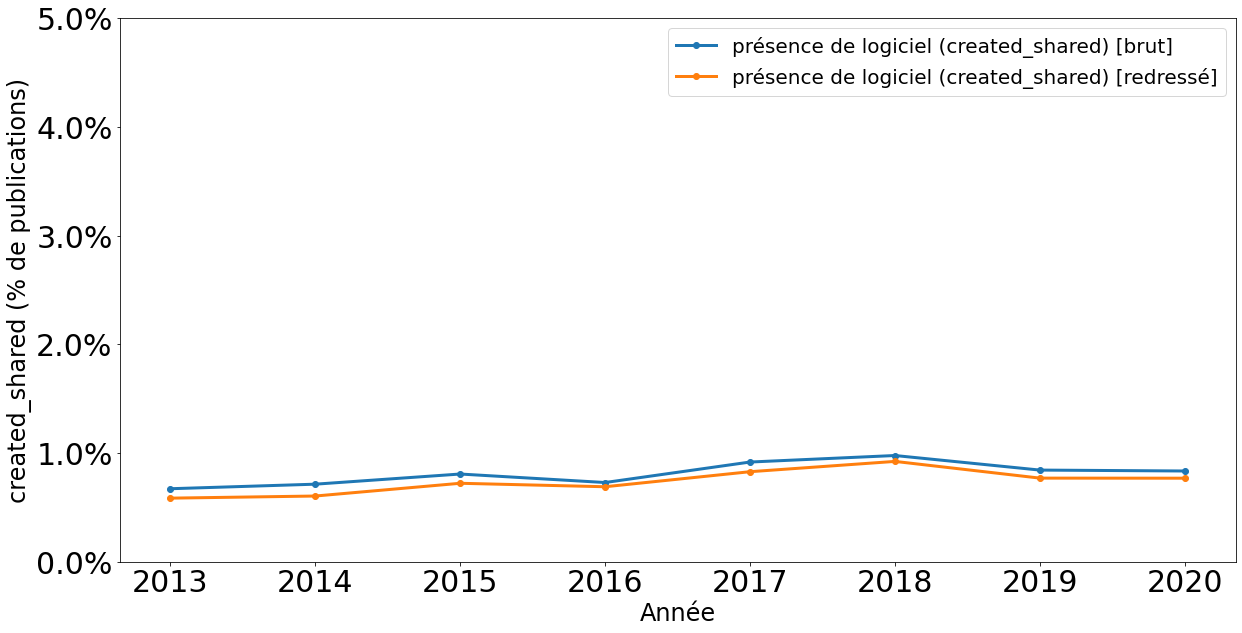

In [401]:
df_tmp = df_publications2.groupby(['year', 'domain'])[f'has_{indicator}'].agg(['count', 'mean']).reset_index()
df_tmp.columns = ['year', 'domain', f'count_{indicator}', f'mean_{indicator}']
df_redresse = pd.merge(df_bso, df_tmp, on=['year', 'domain'])

df_redresse[f'{indicator}_redresse'] = df_redresse[f'mean_{indicator}'] * df_redresse['nb']
df_total = df_redresse.groupby('year')['nb',f'{indicator}_redresse'].apply(lambda x:x.sum())
df_total[f'perc_{indicator}_redresse'] = df_total[f'{indicator}_redresse'] / df_total['nb']

df_brut = df_publications2.groupby(['year'])[f'has_{indicator}'].agg(['mean'])
df_brut.columns=[f'mean_{indicator}']

ax = pd.merge(df_brut, df_total, on='year')[[f'mean_{indicator}', f'perc_{indicator}_redresse']].plot.line(figsize=(20, 10),
                                                                                      fontsize=30,
                                                                                      style='o-',
                                                                                      linewidth=3)
ax.legend([f'présence de logiciel ({indicator}) [brut]', f'présence de logiciel ({indicator}) [redressé]'], fontsize=20)
ax.set_ylabel(f'{indicator} (% de publications)',fontdict={'fontsize':24})
ax.set_xlabel('Année',fontdict={'fontsize':24})
ax.set_ylim(0, 0.05)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



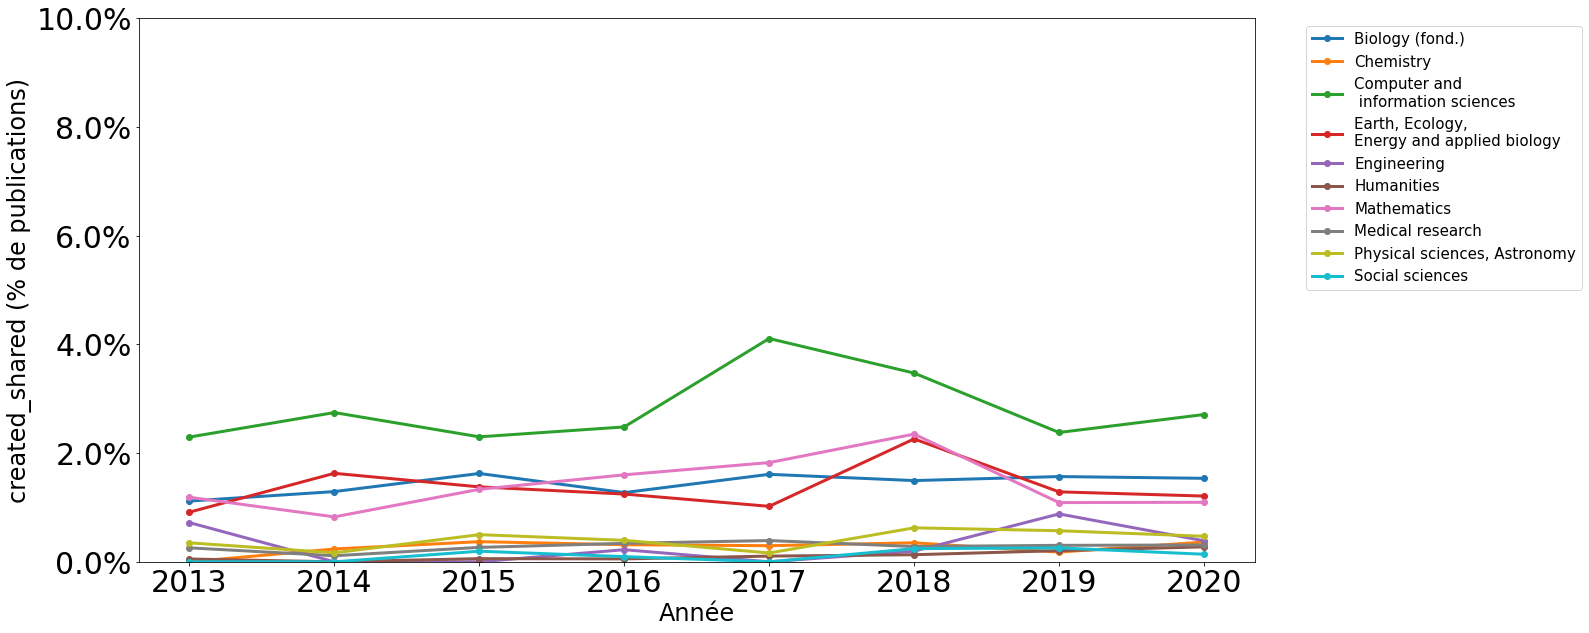

In [407]:
ax2 = pd.pivot_table(df_redresse[df_redresse.domain!='unknown'], index='year', columns='domain', values=f'mean_{indicator}').plot.line(figsize=(20, 10),
                                                                                      fontsize=30,
                                                                                      style='o-',
                                                                                      linewidth=3)
ax2.legend(bbox_to_anchor=(1.0, 1.0, 0.3, 0.), fontsize=15)
ax2.set_ylabel(f'{indicator} (% de publications)',fontdict={'fontsize':24})
ax2.set_xlabel('Année',fontdict={'fontsize':24})
ax2.set_ylim(0, 0.1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))



In [346]:
import random
random.seed(1987)
sh = []
cr = []
crsh = []
for i in range(0, 10000):
    ix = int(random.random()*len(all_m))
    m = all_m[ix]
    if m['mentionContextAttributes']['shared']['value']:
        sh.append(m)
    if m['mentionContextAttributes']['created']['value']:
        cr.append(m)
    
pd.DataFrame(sh).context.values

array(['Marvel website ( http://www.kkrk.chem.elte.hu/ marvelonline ) has a version of Marvel which can be run on- line.',
       'One partic- ular solution for calculating atomic properties, the Gen- eral Relativistic Atomic Structure Package (GRASP), is freely available under the MIT license [16].',
       'All  analysis and visualization scripts and toolboxes, including the FieldTrip toolbox and  megconnectome toolbox used, are available online at  https://gitlab.com/icm-institute/meg/solid_meg .',
       'Custom MATLAB1 script was then used for analysis and is available as a supplement at IST Austria Data Repository, http://dx.doi.org/10.15479/AT:ISTA:45.',
       'More extensive reports of these studies, as well as a selection of other OPERA studies, are available at the OPERA website under the heading "OPERA Publications" [14].',
       'ON GWAS can be accessed via dbGAP (OncoArray: Oral and Pharynx Cancer; study accession number: phs001202.v1.p1) and via the IEU OpenGWAS project

In [347]:
pd.DataFrame(cr).context.values[0:10]

array(['For this paper, the sensitivity analysis will be implemented only for a PISTACHE cooling mode configuration (Fig. 1), which corresponds by the way to the RAFSOL installation (Fig. 2), using both "PISTACHE format" meteorological and load input file.',
       'P.B. developed the AMvBE macro.',
       'To achieve this, our approach integrates results from research on the WoT, MAS, and the Semantic Web.',
       'In the end, Sections 5 will describe our opinion analyzer Doxa, that performs document- level sentiment analysis, sentiment role labeling and feature-based opinion summarization.',
       'For our purpose, we implemented a manipulation tool to add an FMI wrapper around the model before being exported into C/C++.',
       'For the development of applications, we rely on Port, a Map/Reduce programming model in Pharo introduced in  2  prior work [17] which we augmented with a framework for dynamically deploying Pharo on state-of-the-art Hadoop clusters.',
       'The ability 

In [403]:
df_publications2[df_publications2.has_created_shared].sample(10, random_state=0)

,doi,domain,mentions,has_mentions,mentions_used,has_used,mentions_shared,has_shared,mentions_created,has_created,mentions_created_treated,has_created_treated,mentions_created_shared,has_created_shared,soft_created,soft_created_treated,nb_created,nb_created_treated,year,_merge
51679,10.1016/j.virol.2016.03.016,Biology (fond.),"[{'name': 'orfunc', 'nb_mentions': 12, 'used':...",True,"[{'name': 'orfunc', 'nb_mentions': 12, 'used':...",True,"[{'name': 'orfunc', 'nb_mentions': 12, 'used':...",True,"[{'name': 'orfunc', 'nb_mentions': 12, 'used':...",True,[],False,"[{'name': 'orfunc', 'nb_mentions': 12, 'used':...",True,"[orfunc, tool]",[],2,0,2016.0,both
36576,10.1007/978-3-662-47157-9_13,Computer and \n information sciences,"[{'name': 'archi', 'nb_mentions': 16, 'used': ...",True,"[{'name': 'archi', 'nb_mentions': 16, 'used': ...",True,"[{'name': 'archi', 'nb_mentions': 16, 'used': ...",True,"[{'name': 'archi', 'nb_mentions': 16, 'used': ...",True,[],False,"[{'name': 'archi', 'nb_mentions': 16, 'used': ...",True,"[archi, archimate, eclipse, obeo designer]",[],4,0,2015.0,both
79075,10.1002/asi.24495,Computer and \n information sciences,"[{'name': 'scigen', 'nb_mentions': 75, 'used':...",True,"[{'name': 'scigen', 'nb_mentions': 75, 'used':...",True,"[{'name': 'scigen', 'nb_mentions': 75, 'used':...",True,"[{'name': 'scigen', 'nb_mentions': 75, 'used':...",True,[],False,"[{'name': 'scigen', 'nb_mentions': 75, 'used':...",True,[scigen],[],1,0,NaN,left_only
59533,10.1186/1471-2105-15-343,Biology (fond.),"[{'name': 'clap', 'nb_mentions': 33, 'used': T...",True,"[{'name': 'clap', 'nb_mentions': 33, 'used': T...",True,"[{'name': 'clap', 'nb_mentions': 33, 'used': T...",True,"[{'name': 'clap', 'nb_mentions': 33, 'used': T...",True,[],False,"[{'name': 'clap', 'nb_mentions': 33, 'used': T...",True,[clap],[],1,0,2014.0,both
8875,10.1101/674721,Biology (fond.),"[{'name': 'biscot', 'nb_mentions': 26, 'used':...",True,"[{'name': 'biscot', 'nb_mentions': 26, 'used':...",True,"[{'name': 'biscot', 'nb_mentions': 26, 'used':...",True,"[{'name': 'biscot', 'nb_mentions': 26, 'used':...",True,[],False,"[{'name': 'biscot', 'nb_mentions': 26, 'used':...",True,"[biscot, bionano, bionano scaffolding correcti...",[],3,0,2019.0,both
111875,10.1038/s41598-019-46622-w,Biology (fond.),"[{'name': 'cub', 'nb_mentions': 11, 'used': Tr...",True,"[{'name': 'cub', 'nb_mentions': 11, 'used': Tr...",True,"[{'name': 'cuda', 'nb_mentions': 14, 'used': T...",True,"[{'name': 'cub', 'nb_mentions': 11, 'used': Tr...",True,[],False,"[{'name': 'cuda', 'nb_mentions': 14, 'used': T...",True,"[cub, nvidia, cuda, mri, c]",[],5,0,2019.0,both
148882,10.5194/isprs-archives-xlii-2-w15-821-2019,Computer and \n information sciences,"[{'name': 'st', 'nb_mentions': 15, 'used': Tru...",True,"[{'name': 'st', 'nb_mentions': 15, 'used': Tru...",True,"[{'name': 'matlab', 'nb_mentions': 2, 'used': ...",True,"[{'name': 'matlab', 'nb_mentions': 2, 'used': ...",True,[],False,"[{'name': 'matlab', 'nb_mentions': 2, 'used': ...",True,[matlab],[],1,0,2019.0,both
60288,10.15265/iy-2015-026,Medical research,"[{'name': 'bibreview', 'nb_mentions': 2, 'used...",True,"[{'name': 'bibreview', 'nb_mentions': 2, 'used...",True,"[{'name': 'ppisurv', 'nb_mentions': 6, 'used':...",True,"[{'name': 'predictsnp', 'nb_mentions': 6, 'use...",True,[],False,"[{'name': 'ppisurv', 'nb_mentions': 6, 'used':...",True,"[predictsnp, ppisurv, crossplatformcommander]",[],3,0,2015.0,both
185332,10.1101/2021.05.20.444982,Computer and \n information sciences,"[{'name': 'kmerator', 'nb_mentions': 52, 'used...",True,"[{'name': 'kmerator', 'nb_mentions': 52, 'used...",True,"[{'name': 'kmerator', 'nb_mentions': 52, 'used...",True,"[{'name': 'kmerator', 'nb_mentions': 52, 'used...",True,[],False,"[{'name': 'kmerator', 'nb_mentions': 52, 'used...",True,"[kmerator, kmerexplor, ensembl]",[],3,0,NaN,left_only
58293,10.1007/978-1-0716-0278-2_13,Biology (fond.),"[{'name': 'sans', 'nb_mentions': 85, 'used': T...",True,"[{'name': 'sans', 'nb_men

In [405]:
doi = '10.1007/978-1-0716-0278-2_13'
xx = []
for m in df[df.metadata_doi==doi].softcite_mentions.values[0]:
    xx.append({'name': m['software-name']['normalizedForm'].lower().strip(),
              'shared': m['mentionContextAttributes']['shared']['value'],
              'created': m['mentionContextAttributes']['created']['value'],
              'sharedG': m['documentContextAttributes']['shared']['value'],
              'createdG': m['documentContextAttributes']['created']['value'],
              'context': m['context']})
dd = pd.DataFrame(xx).drop_duplicates()
dd[dd.sharedG & dd.createdG & (dd.shared | dd.created)]

,name,shared,created,sharedG,createdG,context
23,sans,False,True,True,True,A novel application of SANS in combination wit...
26,sans,True,False,True,True,An overview of available SANS instruments and...
36,sans,False,True,True,True,Here we provide a short overview of basic SANS...
41,sans,False,True,True,True,Several approaches have been developed to inte...
42,sans,False,True,True,True,In this chapter we have presented the applicat...
50,sans,False,True,True,True,In this book chapter we provide a practical gu...
51,sans,False,True,True,True,This is a remarkable achievement that demonstr...
55,sans,False,True,True,True,We then developed a structure calculation prot...


In [385]:
df_publications2[df_publications2.doi=='10.18564/jasss.3629']

,doi,domain,mentions,has_mentions,mentions_used,has_used,mentions_shared,has_shared,mentions_created,has_created,mentions_created_treated,has_created_treated,has_created_shared,soft_created,soft_created_treated,nb_created,nb_created_treated,year,_merge
8544,10.18564/jasss.3629,Biology (fond.),"[{'name': 'mathematica', 'nb_mentions': 1, 'us...",True,"[{'name': 'matisse', 'nb_mentions': 5, 'used':...",True,"[{'name': 'jasss', 'nb_mentions': 8, 'used': F...",True,"[{'name': 'matisse', 'nb_mentions': 5, 'used':...",True,[],False,True,[matisse],[],1,0,2018.0,both


In [386]:
df[df.metadata_doi==doi].softcite_mentions.values[0]

[{'wikidataId': 'Q81294',
  'wikipediaExternalRef': 49024,
  'lang': 'en',
  'confidence': 0.5987,
  'software-name': {'rawForm': 'Mathematica',
   'normalizedForm': 'Mathematica',
   'wikidataId': 'Q81294',
   'wikipediaExternalRef': 49024,
   'lang': 'en',
   'confidence': 0.5987,
   'offsetStart': 0,
   'offsetEnd': 11,
   'boundingBoxes': [{'p': 9,
     'x': 467.656,
     'y': 301.971,
     'w': 52.0271583333,
     'h': 8.7771}]},
  'type': 'software',
  'context': 'Mathematica, MATLAB, etc.',
  'mentionContextAttributes': {'used': {'value': False, 'score': 0.0014860034},
   'created': {'value': False, 'score': 2.3842e-06},
   'shared': {'value': False, 'score': 2.3840000000000002e-07}},
  'documentContextAttributes': {'used': {'value': False,
    'score': 0.0014860034},
   'created': {'value': False, 'score': 2.3842e-06},
   'shared': {'value': False, 'score': 2.3840000000000002e-07}}},
 {'software-name': {'rawForm': 'MATISSE',
   'normalizedForm': 'MATISSE',
   'offsetStart': 4,


In [19]:
df_publications[df_publications.has_created_treated].soft

,doi,domain,mentions,has_mentions,mentions_used,has_used,mentions_shared,has_shared,mentions_created,has_created,mentions_created_treated,has_created_treated,soft_created,soft_created_treated,nb_created,nb_created_treated
613,10.3390/buildings11070277,Engineering,"[{'name': 'unity', 'nb_mentions': 1, 'used': T...",True,"[{'name': 'unity', 'nb_mentions': 1, 'used': T...",True,[],False,"[{'name': 'unity', 'nb_mentions': 1, 'used': T...",True,"[{'name': 'revit 2018 bim', 'nb_mentions': 1, ...",True,"[unity, autodesk, revit 2018 bim]",[revit 2018 bim],3,1
913,10.1016/j.compgeo.2016.08.006,"Earth, Ecology, \nEnergy and applied biology","[{'name': 'lagamine', 'nb_mentions': 1, 'used'...",True,[],False,[],False,"[{'name': 'lagamine', 'nb_mentions': 1, 'used'...",True,"[{'name': 'lagamine', 'nb_mentions': 1, 'used'...",True,[lagamine],[lagamine],1,1
1681,10.1016/j.robot.2019.103354,Computer and \n information sciences,"[{'name': 'hal', 'nb_mentions': 2, 'used': Tru...",True,"[{'name': 'hal', 'nb_mentions': 2, 'used': Tru...",True,[],False,"[{'name': 'hal', 'nb_mentions': 2, 'used': Tru...",True,"[{'name': 'walkbot', 'nb_mentions': 1, 'used':...",True,"[hal, walkbot]",[walkbot],2,1
2179,10.1109/cdc.2018.8619832,Computer and \n information sciences,"[{'name': 'matlab', 'nb_mentions': 2, 'used': ...",True,"[{'name': 'matlab', 'nb_mentions': 2, 'used': ...",True,[],False,"[{'name': 'matlab toolbox', 'nb_mentions': 1, ...",True,"[{'name': '-parametric toolbox', 'nb_mentions'...",True,"[matlab toolbox, -parametric toolbox]",[-parametric toolbox],2,1
2781,10.1039/d0cc02569k,Chemistry,"[{'name': 'sasview', 'nb_mentions': 1, 'used':...",True,[],False,[],False,"[{'name': 'sasview', 'nb_mentions': 1, 'used':...",True,"[{'name': 'sasview', 'nb_mentions': 1, 'used':...",True,[sasview],[sasview],1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188825,10.1007/978-3-319-63501-9_2,Computer and \n information sciences,"[{'name': 'libieee', 'nb_mentions': 1, 'used':...",True,[],False,[],False,"[{'name': 'libieee', 'nb_mentions': 1, 'used':...",True,"[{'name': 'libieee', 'nb_mentions': 1, 'used':...",True,[libieee],[libieee],1,1
190370,10.1016/j.apenergy.2021.117843,"Earth, Ecology, \nEnergy and applied biology","[{'name': 'medeas', 'nb_mentions': 1, 'used': ...",True,[],False,[],False,"[{'name': 'medeas', 'nb_mentions': 1, 'used': ...",True,"[{'name': 'medeas', 'nb_mentions': 1, 'used': ...",True,[medeas],[medeas],1,1
191109,10.1109/cit/iucc/dasc/picom.2015.49,Computer and \n information sciences,"[{'name': 'piratte', 'nb_mentions': 1, 'used':...",True,[],False,[],False,"[{'name': 'piratte', 'nb_mentions': 1, 'used':...",True,"[{'name': 'piratte', 'nb_mentions': 1, 'used':...",True,[piratte],[piratte],1,1
191139,10.1109/tevc.2020.3035225,Computer and \n information sciences,"[{'name': 'binval', 'nb_mentions': 1, 'used': ...",True,[],False,[],False,"[{'name': 'binval', 'nb_mentions': 1, 'used': ...",True,"[{'name': 'binval', 'nb_mentions': 1, 'used': ...",True,[binval],[binval],1,1


In [18]:
df_publications.groupby('domain').has_created_treated.mean()

domain
Biology (fond.)                                 0.001115
Chemistry                                       0.000512
Computer and \n information sciences            0.009336
Earth, Ecology, \nEnergy and applied biology    0.002926
Engineering                                     0.009756
Humanities                                      0.000306
Mathematics                                     0.004380
Medical research                                0.001039
Physical sciences, Astronomy                    0.003221
Social sciences                                 0.000399
unknown                                         0.000000
Name: has_created_treated, dtype: float64

In [16]:
df_publications.groupby('domain').has_created.mean()

domain
Biology (fond.)                                 0.057927
Chemistry                                       0.024078
Computer and \n information sciences            0.295861
Earth, Ecology, \nEnergy and applied biology    0.095812
Engineering                                     0.128976
Humanities                                      0.010103
Mathematics                                     0.106696
Medical research                                0.023380
Physical sciences, Astronomy                    0.074615
Social sciences                                 0.014970
unknown                                         0.250000
Name: has_created, dtype: float64

In [ ]:
df_publications[df_publications.has_created]

In [ ]:
df_publications[df_publications.has_created].sample(10, random_state=0).mentions_created.values[5]

In [ ]:
df_publications.groupby('domain').has_created.mean()

In [ ]:
df_publications = pd.DataFrame(all_publications)

In [ ]:
df_publications[df_publications.has_created]

In [ ]:
df_m.groupby('domain').has_created.mean()

In [ ]:
df_m = pd.DataFrame(all_m)


In [ ]:
df_m.mentions_created.apply(lambda x)

In [ ]:
df_m[df_m.name=='data']